# Introdução

Você foi alocado(a) em um time da *Indicium* que está trabalhando atualmente junto a um cliente no processo de criação de uma plataforma de aluguéis temporários na cidade de Nova York. Para o desenvolvimento de sua estratégia de precificação, pediu para que a *Indicium* fizesse uma análise exploratória dos dados de seu maior concorrente, assim como um teste de validação de um modelo preditivo.

**Seu objetivo é desenvolver um modelo de previsão de preços a partir do dataset oferecido, e avaliar tal modelo utilizando as métricas de avaliação que mais fazem sentido para o problema**. O uso de outras fontes de dados além do dataset é permitido (e encorajado). Você poderá encontrar em anexo um dicionário dos dados.


# Carregando bibliotecas

In [109]:
# Manipulação dos dados
import pandas as pd
import numpy as np 
from tabulate import tabulate

# Análise exploratória
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
import seaborn as sns
import folium

# Modelagem
from scipy.stats import skew

# Configurações gerais
# Ignorar avisos
import warnings
warnings.filterwarnings('ignore')

# Configurações do Matplotlib
plt.style.use('ggplot')
%matplotlib inline

# Definir exibição máxima de linhas e colunas no Pandas
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

# Quebras e espaçamentos automáticos
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

# Importanção, análise e tratamentos iniciais

## Importação dos dados

In [59]:
df = pd.read_csv('teste_indicium_precificacao.csv')

df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


<IPython.core.display.Javascript object>

## Análise de informações gerais do dataset

In [60]:
print(f'A tabela possui {df.shape[1]} colunas e {df.shape[0]} linhas.')

A tabela possui 16 colunas e 48894 linhas.


<IPython.core.display.Javascript object>

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

<IPython.core.display.Javascript object>

Grande parte das colunas não possui valores nulos, com exceção de *nome*, *host_name*, *ultima_review* e *reviews_por_mes*. Nas duas últimas não há necessidade de averiguarmos a fundo, visto que alguns anúncios podem realmente não conter avaliações. No entanto, *nome* e *host_name* devem ser tratadas, pois são valores imprescindíveis em um anúncio. 

Os tipos de dados também estão em sua maioria corretos. Apenas a coluna *ultima_review* que deve ser transformado para o tipo data.

## Tratamento de valores nulos

Vamos substituir, nas colunas *nome* e *host_name*, os valores nulos por "Sem informação", a coluna *reviews_por_mes* por zero e *ultima_review* será mantido como está, e convertido para o tipo data.

In [62]:
df1 = df.copy()
df1['nome'].fillna('Sem informação', inplace=True)
df1['host_name'].fillna('Sem informação', inplace=True)
df1['reviews_por_mes'].fillna(0, inplace=True)
df1['ultima_review'] = pd.to_datetime(df['ultima_review'], errors='coerce')
df1.isnull().sum()

id                                   0
nome                                 0
host_id                              0
host_name                            0
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                      0
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

<IPython.core.display.Javascript object>

In [63]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             48894 non-null  int64         
 1   nome                           48894 non-null  object        
 2   host_id                        48894 non-null  int64         
 3   host_name                      48894 non-null  object        
 4   bairro_group                   48894 non-null  object        
 5   bairro                         48894 non-null  object        
 6   latitude                       48894 non-null  float64       
 7   longitude                      48894 non-null  float64       
 8   room_type                      48894 non-null  object        
 9   price                          48894 non-null  int64         
 10  minimo_noites                  48894 non-null  int64         
 11  numero_de_revie

<IPython.core.display.Javascript object>

## Composição da tabela

In [64]:
numericas = df1.select_dtypes(include=np.number)
nao_numericas = df1.select_dtypes(exclude=np.number)

print(f'A tabela contém {numericas.shape[1]} colunas numéricas e {nao_numericas.shape[1]} colunas não numéricas.')

A tabela contém 10 colunas numéricas e 6 colunas não numéricas.


<IPython.core.display.Javascript object>

Valores únicos em cada coluna:

In [65]:
df1.nunique().sort_values()

room_type                            3
bairro_group                         5
calculado_host_listings_count       47
minimo_noites                      109
bairro                             221
disponibilidade_365                366
numero_de_reviews                  394
price                              674
reviews_por_mes                    938
ultima_review                     1764
host_name                        11453
longitude                        14718
latitude                         19048
host_id                          37457
nome                             47905
id                               48894
dtype: int64

<IPython.core.display.Javascript object>

Verificando se não existem linhas duplicadas:

In [66]:
df1.duplicated().sum()

0

<IPython.core.display.Javascript object>

Perfeito! Nenhuma linha duplicada!

# Análise exploratória dos dados

### Preços

Olhando de forma mais ampla, vamos analisar os preços:

In [67]:
descricao = df1['price'].describe()
descricao['var'] = df1['price'].var()
descricao['kurt'] = df1['price'].kurtosis()
descricao = pd.DataFrame(descricao)
print(tabulate(descricao, headers='keys', tablefmt='psql', showindex=True))

+-------+-----------+
|       |     price |
|-------+-----------|
| count | 48894     |
| mean  |   152.721 |
| std   |   240.157 |
| min   |     0     |
| 25%   |    69     |
| 50%   |   106     |
| 75%   |   175     |
| max   | 10000     |
| var   | 57675.2   |
| kurt  |   585.661 |
+-------+-----------+


<IPython.core.display.Javascript object>

Baseado na tabela montada acima, podemos observar que o **preço médio** por noite em um apartamento de Nova York é de aproximadamente **U\$ 152,72**. No entanto, o **desvio padrão de U\$ 240,16** nos remete a uma variação enorme entre os preços apresentados.

A **mediana é igual a U\$ 106,00**, bem menor que a média, isso quer dizer que temos dados muito desbalanceados para a direita. O altíssimo valor da curtose (585,661) confirma essa distribuição assimétrica para o lado direito, indicando outliers de preços bem acima da mediana.

Os quartis superior e inferior nos mostram que a maior parte dos preços estão **entre U$ 69,00 e U\$ 175,00**.

A presença de preços iguais a zero também já nos acende um alerta em alguma incompatibilidade nos dados, visto que seria impraticável a presença de um anúncio assim.

Não é muito provável um anúncio com preço igual a zero, não é mesmo? Vamos analisar.

In [68]:
anuncios_preco_zero = df1[df1['price'] == 0]
display(anuncios_preco_zero.head())

print()
print()
print(f'Foram encontrados {len(anuncios_preco_zero)} anúncios com preço igual a zero.')

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
23160,18750597,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Kimberly,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,4,1,2018-01-06,0.05,4,28
25432,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,2019-06-24,2.56,4,127
25633,20523843,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",15787004,Martial Loft,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,2019-05-18,0.71,5,0
25752,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,2017-10-27,0.53,2,0
25777,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,2018-01-02,0.15,1,73




Foram encontrados 11 anúncios com preço igual a zero.


<IPython.core.display.Javascript object>

Vamos solucionar esse problema removendo essas linhas, para não interferir em nossa análise.

In [69]:
df2 = df1.copy()
df2 = df1.loc[df1['price'] != 0]

<IPython.core.display.Javascript object>

In [70]:
media = df2['price'].mean()
media_formatada = ('U$ {:,.2f}'.format(media).replace(',', 'v').replace('.', ',').replace('v', '.'))

precos_outliers_sup = df2.query(f'price >= 5000')

print(f'''Além disso, também possuímos alguns outliers superiores. Considerando que a média de preços por anúncio é de {media_formatada}, valores muito altos, acima de U$ 5.000,00 podem acender um
alerta. Temos {len(precos_outliers_sup)} anúncios com preços iguais ou superiores a U$ 5.000.''')

print()

display(precos_outliers_sup.sample(5))


Além disso, também possuímos alguns outliers superiores. Considerando que a média de preços por anúncio é de U$ 152,76, valores muito altos, acima de U$ 5.000,00 podem acender um
alerta. Temos 26 anúncios com preços iguais ou superiores a U$ 5.000.



,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
17691,13894339,Luxury 1 bedroom apt. -stunning Manhattan views,5143901,Erin,Brooklyn,Greenpoint,40.73260,-73.95739,Entire home/apt,10000,5,5,2017-07-27,0.16,1,0
29661,22779726,East 72nd Townhouse by (Hidden by Airbnb),156158778,Sally,Manhattan,Upper East Side,40.76824,-73.95989,Entire home/apt,7703,1,0,NaT,0.00,12,146
30267,23377410,Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho,18128455,Rum,Manhattan,Tribeca,40.72197,-74.00633,Entire home/apt,8500,30,2,2018-09-18,0.18,1,251
22352,18051877,Victorian Film location,2675644,Alissa,Staten Island,Randall Manor,40.63952,-74.09730,Entire home/apt,5000,1,0,NaT,0.00,1,344
44033,33998396,3000 sq ft daylight photo studio,3750764,Kevin,Manhattan,Chelsea,40.75060,-74.00388,Entire home/apt,6800,1,0,NaT,0.00,6,364


<IPython.core.display.Javascript object>

O procedimento correto seria recorrer a pessoa ou equipe responsável pela coleta dos dados, para garantir a qualidade e fidedignidade dos dados. Como nesse caso isso não é possível, 
vamos considerar que sejam realmente anúncios de imóveis de alto padrão e mantê-los no dataset.

Agora que tratamos esses outliers, vamos retomar nossa análise de preços:

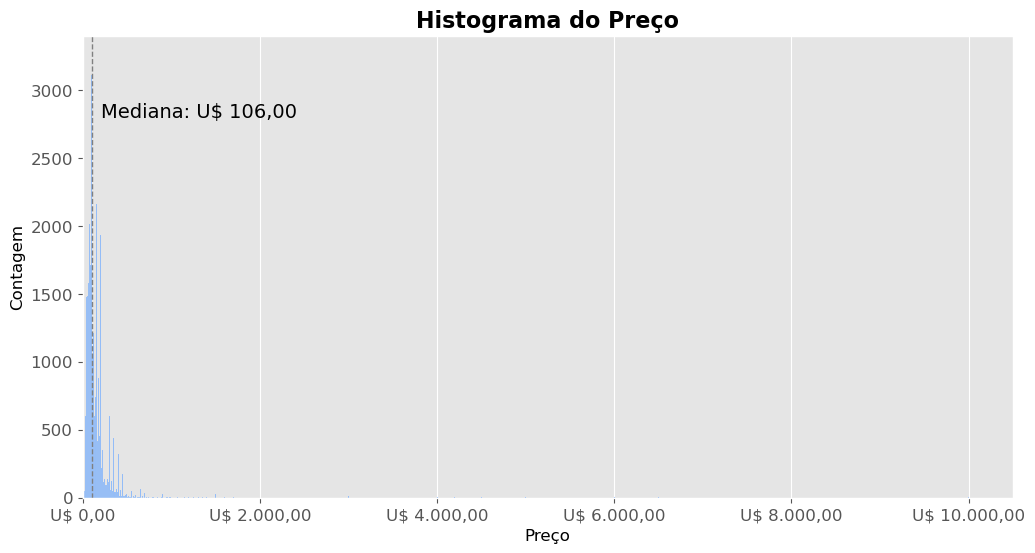

<IPython.core.display.Javascript object>

In [71]:
fig, ax = plt.subplots(figsize=(12,6))
mediana = df2.price.median()
mediana_format = ('U$ {:,.2f}'.format(mediana).replace(',', 'v').replace('.', ',').replace('v', '.'))

sns.histplot(df2.price, color='#73ACFF')
plt.axvline(mediana, color='grey', linestyle='dashed', linewidth=1)
plt.title('Histograma do Preço', fontsize=16, fontweight='bold')
plt.xlabel('Preço', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
formatter = mtick.FuncFormatter(lambda x, _: 'U$ {:,.2f}'.format(x).replace(',', 'v').replace('.', ',').replace('v', '.'))
ax.xaxis.set_major_formatter(formatter)
ax.grid(False, axis='y')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0)
plt.text(x=df2.price.median()+100, y=2800, s=f'Mediana: {mediana_format}', fontsize=14)
plt.show();

### Bairros

Como os anúncios estão distribuidos por bairro?

A plataforma possui anúncios em 5 bairros diferentes, sendo eles:
Manhattan, com 44.3% dos anúncios
Brooklyn, com 41.1% dos anúncios
Queens, com 11.6% dos anúncios
Staten Island, com 0.8% dos anúncios
Bronx, com 2.2% dos anúncios


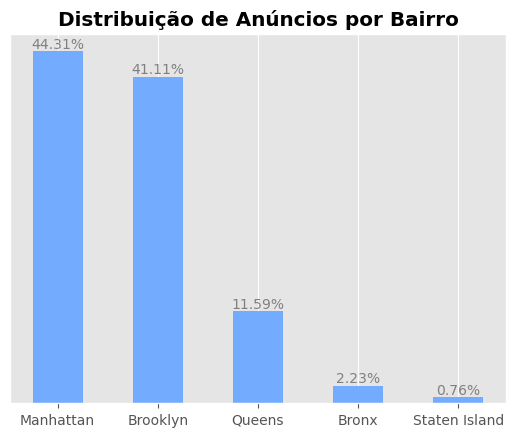

<IPython.core.display.Javascript object>

In [72]:
quantidade_bairros = len(df2.bairro_group.unique())

print(f'A plataforma possui anúncios em {quantidade_bairros} bairros diferentes, sendo eles:')
for bairro in df2.bairro_group.unique():
    percentual_ocorrencia = round(len(df2[df2['bairro_group']==bairro])/len(df2)*100, 1)
    print(f'{bairro}, com {percentual_ocorrencia}% dos anúncios')

fig, ax = plt.subplots()


x = df2.bairro_group.value_counts().keys()
y = df2.bairro_group.value_counts(normalize=True)

barra = ax.bar(x, y, width=0.5, color='#73ACFF')

plt.title('Distribuição de Anúncios por Bairro', fontweight='bold')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))

ax.set_xticks(np.arange(len(x)))
plt.gca().get_yaxis().set_visible(False)
ax.set_xticklabels(tuple(x), ha='center')
ax.bar_label(barra, labels=[f'{i*100:.2f}%' for i in y.values], color='grey')

plt.show();

Agora, vamos analisar como o preço está distribuido em cada bairro:

,count,mean,std,min,25%,50%,75%,max
bairro_group,,,,,,,,
Manhattan,21660.0,196.88,291.39,10.0,95.0,150.0,220.0,10000.0
Brooklyn,20094.0,124.44,186.90,10.0,60.0,90.0,150.0,10000.0
Staten Island,373.0,114.81,277.62,13.0,50.0,75.0,110.0,5000.0
Queens,5666.0,99.52,167.10,10.0,50.0,75.0,110.0,10000.0
Bronx,1090.0,87.58,106.73,10.0,45.0,65.0,99.0,2500.0


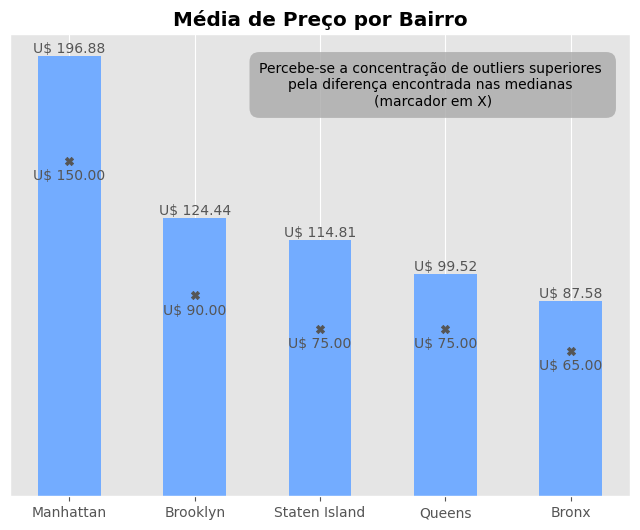

Manhattan e Brooklyn, mesmo sendo as maiores amostras do dataset, possuem as maiores médias de preço.


<IPython.core.display.Javascript object>

In [73]:
preco_bairro = df2.groupby('bairro_group')['price'].describe().round(2).sort_values(by='mean', ascending=False)
display(preco_bairro)

fig, ax = plt.subplots(figsize=(8,6))

x = preco_bairro.index
y = preco_bairro['mean']

barra = ax.bar(x, y, width=0.5, color='#73ACFF')

medianas = preco_bairro['50%']
ax.scatter(x, medianas, marker='X', color='#555555', zorder=3)
for i, v in enumerate(medianas):
    ax.text(i, v-10, f'U$ {v:.2f}', ha='center', va='bottom', color='#555555')

plt.title('Média de Preço por Bairro', fontweight='bold')
plt.gca().get_yaxis().set_visible(False)

ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(tuple(x), ha='center')
ax.bar_label(barra, labels=[f'U$ {i:.2f}' for i in y.values], color='#555555')
ax.text(2.9, 175, 'Percebe-se a concentração de outliers superiores \npela diferença encontrada nas medianas \n(marcador em X)', 
        bbox={'facecolor': 'darkgrey', 'alpha':0.8, 'pad': 0.7, 'edgecolor': 'none', 'boxstyle': 'round'}, ha='center')

plt.show();

Vamos abrir em uma visão geral sobre como as colunas numéricas se comportam de acordo com os bairros:

In [ ]:
agg_func = {
    'price':['min', 'median', 'mean', 'std', skew],
    'minimo_noites':['min', 'median', 'mean', 'std', skew],
    'numero_de_reviews':['min', 'median', 'mean', 'std', skew],
    'reviews_por_mes':['min', 'median', 'mean', 'std', skew],
    'calculado_host_listings_count':['min', 'median', 'mean', 'std', skew]
}

df2.groupby('bairro_group').agg(agg_func)

price                                           minimo_noites  \
                min median        mean         std       skew           min   
bairro_group                                                                  
Bronx            10   65.0   87.577064  106.725371  12.493704             1   
Brooklyn         10   90.0  124.437693  186.901408  23.465343             1   
Manhattan        10  150.0  196.884903  291.386838  15.946238             1   
Queens           10   75.0   99.517649  167.102155  39.151557             1   
Staten Island    13   75.0  114.812332  277.620403  15.031420             1   

                                                     numero_de_reviews         \
              median      mean        std       skew               min median   
bairro_group                                                                    
Bronx            2.0  4.563303  15.638775  14.324931                 0    9.0   
Brooklyn         3.0  6.055738  17.635297  20.629041                 0    6.0   
Manhattan        3.0  8.579409  24.051383  21.366054                 0    4.0   
Queens           2.0  5.181433  15.028725  18.712365                 0    7.0   
Staten Island    2.0  4.831099  19.727605  16.484032                 0   12.0   

                                              reviews_por_mes         \
                    mean        std      skew             min median   
bairro_group                                                           
Bronx          25.977982  42.225003  2.935565             0.0   0.87   
Brooklyn       24.198417  44.346333  3.260489             0.0   0.38   
Manhattan      20.986565  42.573021  3.892750             0.0   0.28   
Queens         27.700318  51.955853  4.196021             0.0   0.76   
Staten Island  30.941019  44.830766  2.523924             0.0   1.00   

                                            calculado_host_listings_count  \
                   mean       std      skew                           min   
bairro_group                                                                
Bronx          1.474661  1.668538  1.463106                             1   
Brooklyn       1.049565  1.457772  2.078369                             1   
Manhattan      0.976827  1.524539  4.682136                             1   
Queens         1.567076  2.130754  2.525402                             1   
Staten Island  1.576381  1.690710  1.744826                             1   

                                                       
              median       mean        std       skew  
bairro_group                                           
Bronx            1.0   2.232110   2.371060   4.788701  
Brooklyn         1.0   2.283119   5.274623  14.787126  
Manhattan        1.0  12.791874  48.235813   5.314480  
Queens           1.0   4.060184  12.445003   7.168930  
Staten Island    1.0   2.319035   1.915580   1.544199

<IPython.core.display.Javascript object>

Alguns pontos que valem ser destacados:
* **Manhattan** possui a maior média de preço e mínimo de noites, mas o que mais chama a atenção é a disparidade na **média de anúncios pelo mesmo anfitrião**. Pode ser averiguado se não está ocorrendo uma espécie de oligopólio dos imóveis do bairro por um grupo de anfitriões.
* Quase todas as variáveis possuem características de **presença de outliers**.
* Os **preços em Queens** possui um **"skew"** bem mais alto que os demais, praticamente o dobro de todos os outros, que também são altos. Isso quer dizer que sua **distribuição de preços está muito assimétrica para a direita**, devido a um grande número de outliers.

Vamos expandir a análise e observar as áreas de cada bairro. Chamaremos de distritos.

São 221 distritos presentes no DataFrame. Vamos observar aqueles com a maior quantidade de anúncios: 


,Bairro,Distrito,Quantidade
0,Brooklyn,Williamsburg,3919
1,Brooklyn,Bedford-Stuyvesant,3710
2,Manhattan,Harlem,2658
3,Brooklyn,Bushwick,2462
4,Manhattan,Upper West Side,1971
5,Manhattan,Hell's Kitchen,1958
6,Manhattan,East Village,1853
7,Manhattan,Upper East Side,1798
8,Brooklyn,Crown Heights,1564
9,Manhattan,Midtown,1545


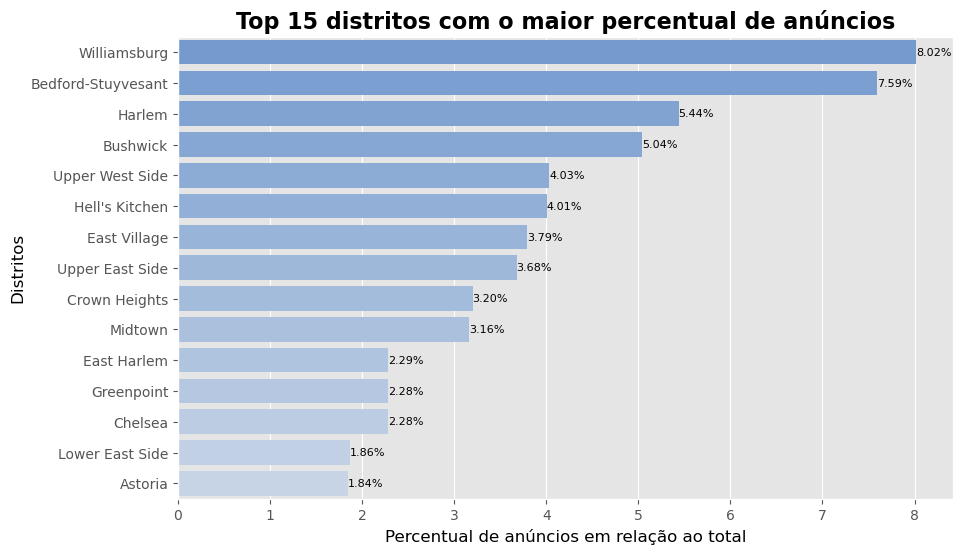

<IPython.core.display.Javascript object>

In [183]:
numero_distritos = len(df2['bairro'].unique())
print(f'São {numero_distritos} distritos presentes no DataFrame. Vamos observar aqueles com a maior quantidade de anúncios: ')

top_distritos = df2.groupby('bairro').size().sort_values(ascending=False).reset_index(name='Quantidade')[:15]

for index, bairro in top_distritos['bairro'].items():
    top_distritos.loc[index, 'Bairro'] = df2['bairro_group'].loc[df2['bairro'] == bairro].iloc[0]
    
top_distritos = top_distritos.reindex(columns=['Bairro', 'bairro', 'Quantidade'])
top_distritos.columns = ['Bairro', 'Distrito', 'Quantidade']
top_distritos_percentual = top_distritos['Quantidade']/len(df2)*100
display(top_distritos)

fig, ax = plt.subplots(figsize=(10,6))

ax = sns.barplot(data=top_distritos, x=top_distritos_percentual, y='Distrito', palette = sns.light_palette("#69d", 22, reverse=True))
ax.bar_label(ax.containers[0], fmt='%.2f%%', fontsize=8)

plt.title('Top 15 distritos com o maior percentual de anúncios', fontsize=16, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Percentual de anúncios em relação ao total', fontsize=12)
plt.ylabel('Distritos', fontsize=12)
plt.show();


### Análise de geolocalização

Vamos analisar, no mapa, como estão distribuídos os anúncios mais caros.

In [77]:
sample = df2.query('price > 2000')
centro_ny_coordenadas = [40.7128, -74.0060]

mapa = folium.Map(location=centro_ny_coordenadas, zoom_start=11)
folium.Marker(centro_ny_coordenadas, tooltip='Centro de Nova York', icon=folium.Icon(color='red', icon='glyphicon-home', prefix='glyphicon'), 
              icon_size=(30, 30)).add_to(mapa)

cores_bairros = {'Manhattan': 'darkblue', 'Brooklyn': 'green', 'Queens': 'orange', 'Staten Island': 'purple', 'Bronx': 'lightblue'}

for indice, linha in sample.iterrows():
    
    folium.Marker([linha['latitude'], linha['longitude']], tooltip=(f'Anúncio: {linha["nome"]} | Distrito: {linha["bairro"]} | Preço: {linha["price"]}'),
                  icon=folium.Icon(color=cores_bairros[linha['bairro_group']])).add_to(mapa)

mapa


<IPython.core.display.Javascript object>

Aqui, mostramos anúncios com preços superiores a U$ 2.000,00. A cor do marcador representa o bairro em que o anúncio se encontra, sendo:
* Azul-escuro: Manhattan;
* Verde: Brooklyn;
* Laranja: Queens;
* Azul-claro: Bronx;
* Roxo: Staten Island.

Obs.: Passando o mouse por cima do marcador, você verá informações como o nome, distrito e preço do anúncio.

### Anúncios por anfitrião

In [83]:
quantidade_hosts = len(df2.host_id.unique())
quantidade_imoveis = len(df2)
media_imoveis = round(quantidade_imoveis/quantidade_hosts,2)
host_mais_frequente = df2.host_id.value_counts().max()
host_menos_frequente = df2.host_id.value_counts().min()

print(f'''Estão cadastrados {quantidade_hosts} anfitriões, e cada um possui entre {host_menos_frequente} e {host_mais_frequente} imóveis.
No total, são {quantidade_imoveis} imóveis cadastrados, uma média de {media_imoveis} imóveis por anfitrião.''')

print()
print('A seguir, uma tabela com a faixa de valores de quantidade de anúncios por anfitrião:')

contagem_anuncios = df2['host_id'].value_counts()

df_contagem = pd.DataFrame({'host_id': contagem_anuncios.index, 'frequencia': contagem_anuncios.values})

faixas = [0, 2, 3, 6, 11, 21, 51, 101, float('inf')]
rotulos = ['1', '2', '3 a 5', '6 a 10', '11 a 20', '20 a 50', '51 a 100', '100+']

df_contagem['Anúncios'] = pd.cut(df_contagem['frequencia'], bins=faixas, labels=rotulos, right=False)

tabela_frequencia = df_contagem.groupby('Anúncios').size().reset_index(name='Quantidade')

display(tabela_frequencia)

Estão cadastrados 37455 anfitriões, e cada um possui entre 1 e 327 imóveis.
No total, são 48883 imóveis cadastrados, uma média de 1.31 imóveis por anfitrião.

A seguir, uma tabela com a faixa de valores de quantidade de anúncios por anfitrião:


,Anúncios,Quantidade
0,1,32302
1,2,3328
2,3 a 5,1483
3,6 a 10,248
4,11 a 20,56
5,20 a 50,27
6,51 a 100,7
7,100+,4


<IPython.core.display.Javascript object>

### Tipos de espaços

In [84]:
import plotly.express as px

cores = {
    'Entire home/apt': '#440160',
    'Private room': '#482879',
    'Shared room': '#31688f'
}

fig = px.histogram(df2, x='room_type', color='room_type', color_discrete_map=cores)
fig.update_layout(title='Distribuição dos tipos de espaços',
                  xaxis_title='Tipo de espaço',
                  yaxis_title='Contagem')
fig.show()

<IPython.core.display.Javascript object>

In [80]:
preco_tipo = df2.groupby('room_type')['price'].describe().round(2).sort_values(by='mean', ascending=False)
display(preco_tipo)

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,25409.0,211.79,284.04,0.0,120.0,160.0,229.0,10000.0
Private room,22325.0,89.78,160.21,0.0,50.0,70.0,95.0,10000.0
Shared room,1160.0,70.13,101.73,0.0,33.0,45.0,75.0,1800.0


<IPython.core.display.Javascript object>

Observamos muitos anúncios para casas ou apartamentos inteiros e também para quartos privativos. Quartos compartilhados possuem pouquíssimos anúncios, algo que talvez possa ser investigado se é de fato pela baixa procura por esse tipo de acomodação ou por ser um nicho não tão explorado ainda.

### Boxplots de bairro e tipo de espaço

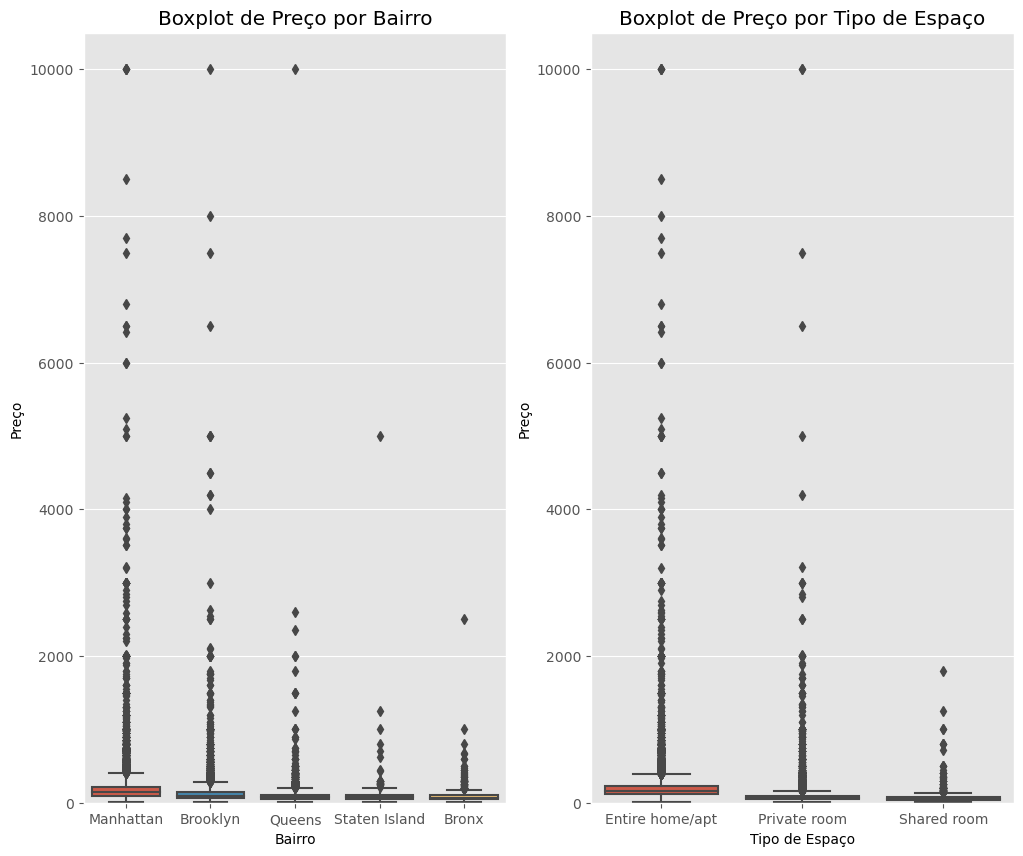

<IPython.core.display.Javascript object>

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10))

sns.boxplot(data=df2, x='bairro_group', y='price', ax=axes[0])
sns.boxplot(data=df2, x='room_type', y='price', ax=axes[1])

axes[0].set_xlabel('Bairro')
axes[0].set_ylabel('Preço')
axes[0].set_title('Boxplot de Preço por Bairro')
axes[0].set_ylim(0)

axes[1].set_xlabel('Tipo de Espaço')
axes[1].set_ylabel('Preço')
axes[1].set_title('Boxplot de Preço por Tipo de Espaço')
axes[1].set_ylim(0)
plt.show();

In [101]:
q1 = df2['price'].quantile(0.25)
q3 = df2['price'].quantile(0.75)
iqr = q3 - q1
limite_inf = q1 - 1.5 * iqr
limite_sup = q3 + 1.5 * iqr

outliers = df2['price'][df2['price'] < limite_inf] | df2['price'][df2['price'] > limite_sup]
porcentagem_outliers = len(outliers) / len(df2) * 100

print(f"Porcentagem de outliers: {round(porcentagem_outliers, 2)}%")



Porcentagem de outliers: 6.08%


<IPython.core.display.Javascript object>

### Analisando correlação de colunas numéricas

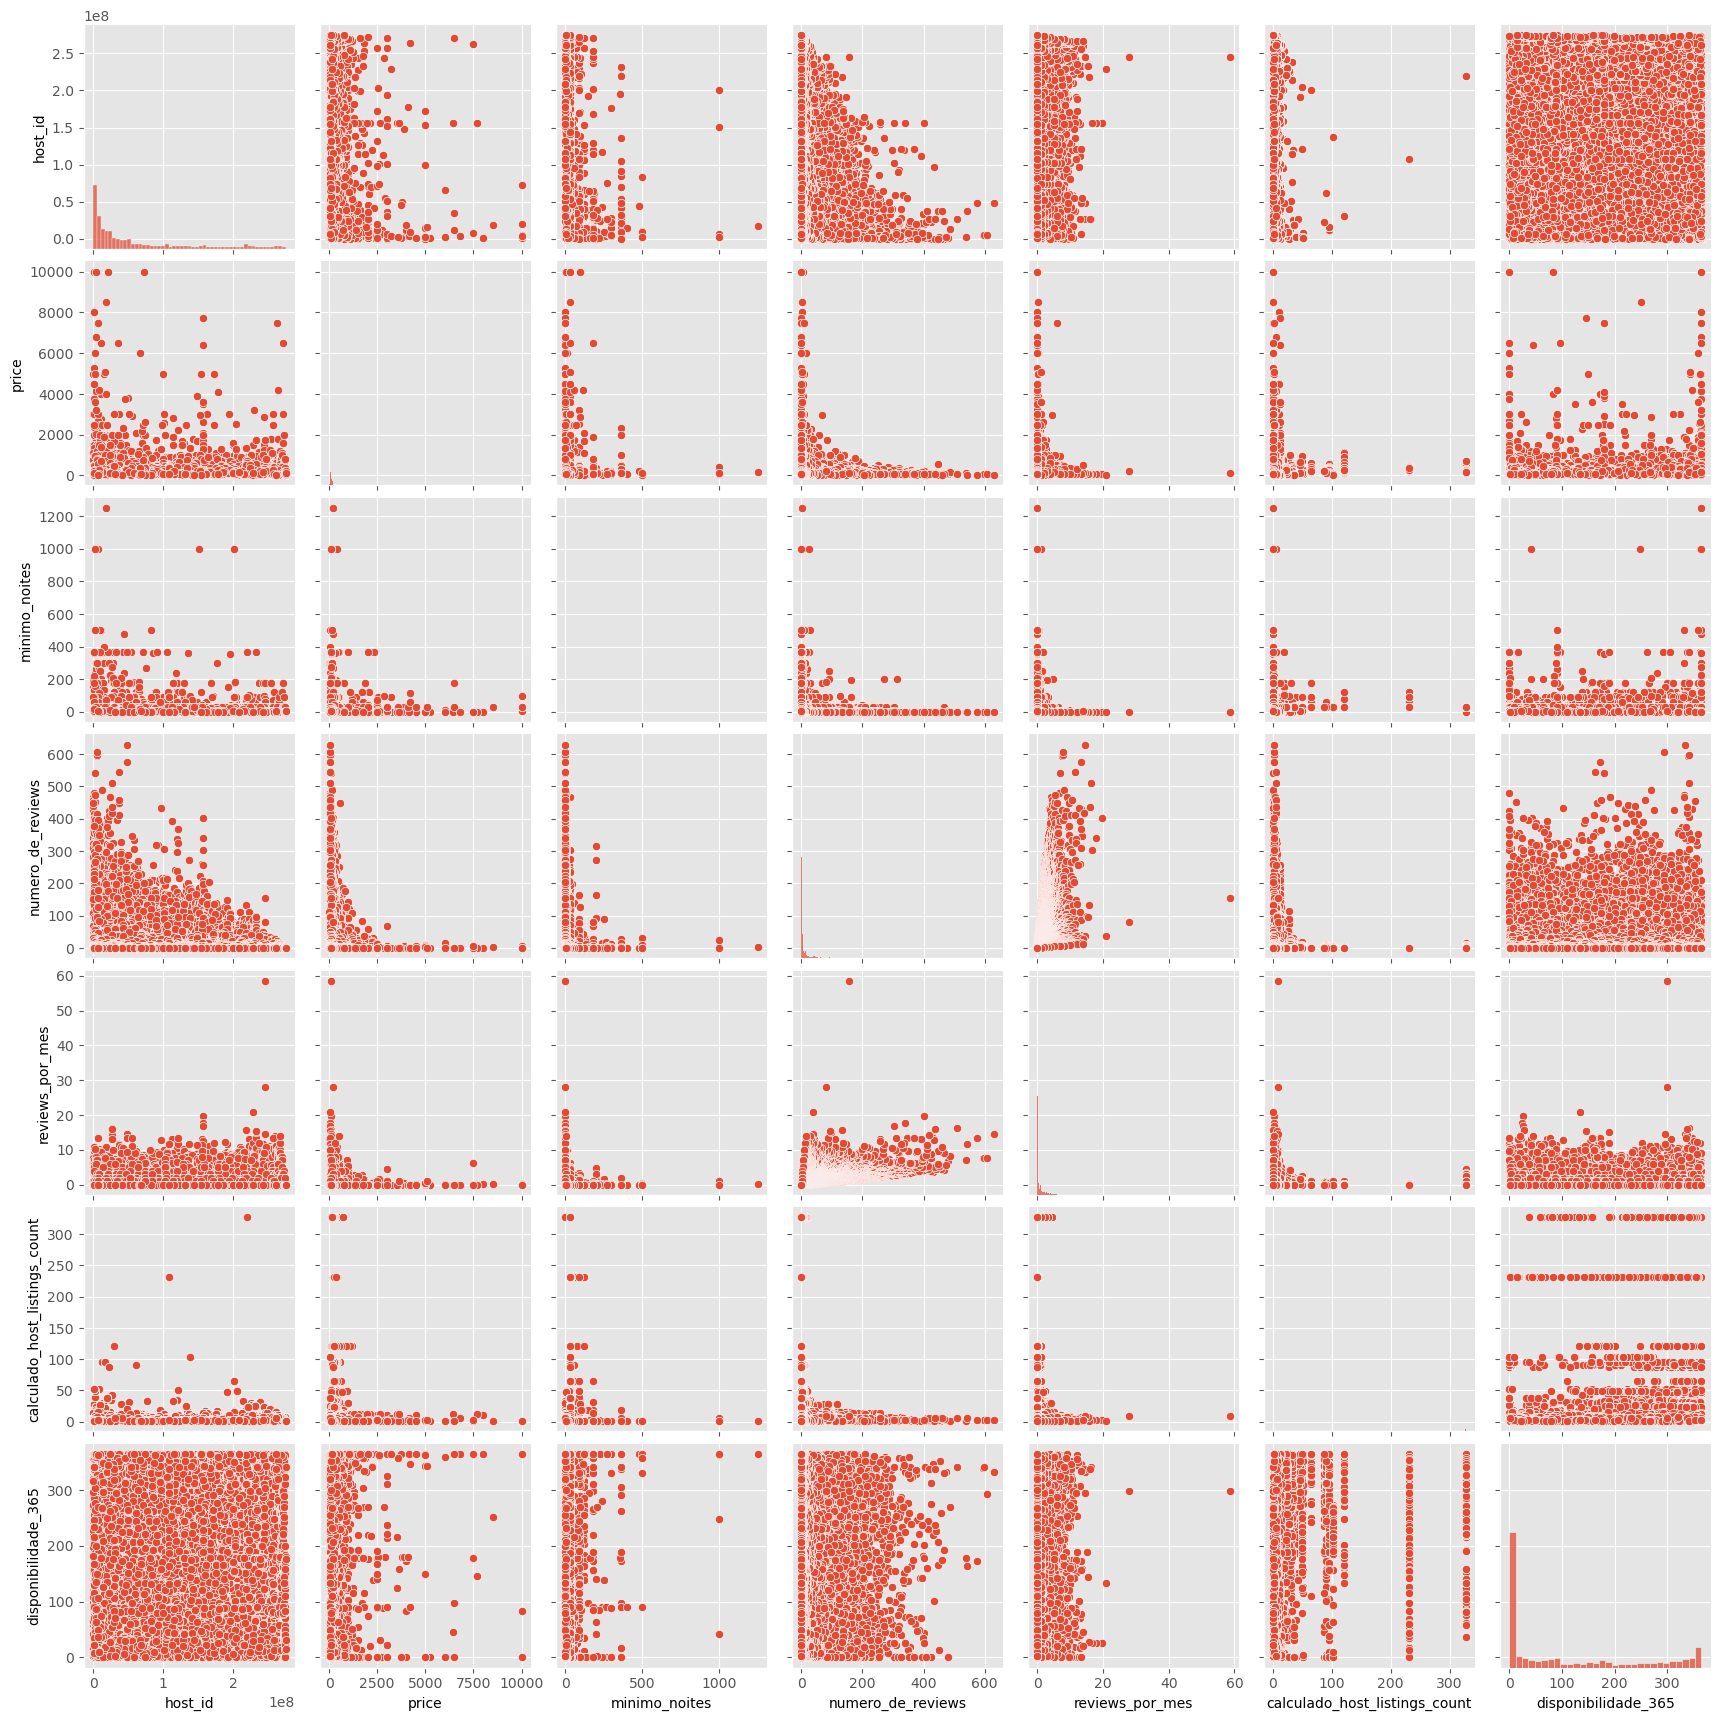

<IPython.core.display.Javascript object>

In [106]:
matplotlib.use('module://ipykernel.pylab.backend_inline')

colunas_analisadas = ['host_id', 'price', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']
sns.pairplot(df2[colunas_analisadas]);

In [ ]:
filtered_words_expensive = list(filter(lambda x: len(x) >= 2, words_expensive))

In [ ]:
# Filter expensive listings
expensive_listings = pd.DataFrame(df).query('price > 300')

# Extract words from "nome" column
words_expensive = expensive_listings['nome'].str.split().explode().str.lower()


# Count word frequency
word_counts_expensive = words_expensive.value_counts()
word_percentage_expensive = word_counts_expensive/len(words_expensive)*100

# Sort words by frequency in descending order
sorted_words_expensive = word_counts_expensive.sort_values(ascending=False)
sorted_percentage_expensive = word_percentage_expensive.sort_values(ascending=False)

sorted_words_expensive = pd.DataFrame({'Palavras': sorted_words_expensive.index, 'Contagem': sorted_words_expensive.values, 'Porcentagem': sorted_percentage_expensive.values})

# Filter out words with less than 2 characters
filtered_sorted_words_expensive = sorted_words_expensive[sorted_words_expensive['Palavras'].str.len() > 2]

# Display the first 30 filtered words
display(filtered_sorted_words_expensive.head(30))

,Palavras,Contagem,Porcentagem
2,bedroom,414,1.861343
3,luxury,345,1.551120
4,apartment,313,1.407248
5,loft,310,1.393760
6,the,270,1.213920
7,apt,245,1.101520
8,with,234,1.052064
10,park,222,0.998112
12,village,221,0.993616
13,manhattan,208,0.935168


<IPython.core.display.Javascript object>

In [ ]:
# Filter expensive listings
listings = df

# Extract words from "nome" column
words = listings['nome'].str.split().explode().str.lower()

# Count word frequency
word_counts = words.value_counts()
word_percentage = word_counts/len(words)*100

# Sort words by frequency in descending order
sorted_words = word_counts.sort_values(ascending=False)
sorted_percentage = word_percentage.sort_values(ascending=False)

sorted_words = pd.DataFrame({'Palavras': sorted_words.index, 'Contagem': sorted_words.values, 'Porcentagem': sorted_percentage.values})

filtered_sorted_words = sorted_words[sorted_words['Palavras'].str.len() > 2]
display(filtered_sorted_words.head(30))

,Palavras,Contagem,Porcentagem
1,room,9389,3.144035
2,bedroom,7231,2.421399
3,private,6985,2.339023
4,apartment,6113,2.047022
5,cozy,4634,1.551758
6,the,3868,1.295253
8,studio,3772,1.263106
9,brooklyn,3629,1.215220
10,apt,3570,1.195463
11,spacious,3387,1.134183


<IPython.core.display.Javascript object>

In [ ]:
from collections import Counter

# Extraindo as colunas como listas
lista1 = filtered_sorted_words['Palavras'].tolist()
lista2 = filtered_sorted_words_expensive['Palavras'].tolist()

# Contando a frequência dos itens em cada lista
contagem_lista1 = Counter(lista1)
contagem_lista2 = Counter(lista2)

# Selecionando os 30 itens mais comuns em cada lista
top30_lista1 = set(item for item, _ in contagem_lista1.most_common(30))
top30_lista2 = set(item for item, _ in contagem_lista2.most_common(30))

# Encontrando os valores comuns entre os 30 itens mais comuns em cada lista
valores_comuns = top30_lista1.intersection(top30_lista2)

# Encontrando os valores presentes em lista2 mas não em lista1
valores_exclusivos_lista2 = top30_lista2 - top30_lista1

# Imprimindo os valores comuns e suas diferenças de posição
print("Valores comuns e diferença de posição nas palavras de anúncios caros:")
for valor in valores_comuns:
    diferenca_de_posicao = (lista1.index(valor)+1) - (lista2.index(valor)+1)
    if diferenca_de_posicao < 0:
        print(f"palavra: {valor} \nposição anuncios caros: {lista2.index(valor)+1} \ndesceu {abs(diferenca_de_posicao)} posições.\n")
    elif diferenca_de_posicao > 0:
        print(f"palavra: {valor} \nposição anuncios caros: {lista2.index(valor)+1} \nsubiu {diferenca_de_posicao} posições.\n")

# Imprimindo os valores exclusivos de lista2
print("\nValores exclusivos nos anuncios caros:")
for valor in valores_exclusivos_lista2:
    print(f"palavra: {valor} / posição: {lista2.index(valor)}.")


Valores comuns e diferença de posição nas palavras de anúncios caros:
palavra: near 
posição anuncios caros: 23 
desceu 5 posições.

palavra: loft 
posição anuncios caros: 4 
subiu 19 posições.

palavra: west 
posição anuncios caros: 15 
subiu 15 posições.

palavra: apartment 
posição anuncios caros: 3 
subiu 1 posições.

palavra: bedroom 
posição anuncios caros: 1 
subiu 1 posições.

palavra: luxury 
posição anuncios caros: 2 
subiu 27 posições.

palavra: park 
posição anuncios caros: 8 
subiu 7 posições.

palavra: spacious 
posição anuncios caros: 19 
desceu 9 posições.

palavra: brooklyn 
posição anuncios caros: 17 
desceu 9 posições.

palavra: studio 
posição anuncios caros: 27 
desceu 20 posições.

palavra: apt 
posição anuncios caros: 6 
subiu 3 posições.

palavra: manhattan 
posição anuncios caros: 10 
subiu 4 posições.

palavra: modern 
posição anuncios caros: 24 
subiu 3 posições.

palavra: with 
posição anuncios caros: 7 
subiu 4 posições.

palavra: nyc 
posição anuncios caro

<IPython.core.display.Javascript object>

In [ ]:
# Extraindo as colunas como listas
lista1 = filtered_sorted_words['Palavras'].tolist()
lista2 = filtered_sorted_words_expensive['Palavras'].tolist()

# Contando a frequência dos itens em cada lista
contagem_lista1 = Counter(lista1)
contagem_lista2 = Counter(lista2)

# Selecionando os 30 itens mais comuns em cada lista
top30_lista1 = set(item for item, _ in contagem_lista1.most_common(30))
top30_lista2 = set(item for item, _ in contagem_lista2.most_common(30))

# Encontrando os valores comuns entre os 30 itens mais comuns em cada lista
valores_comuns = top30_lista1.intersection(top30_lista2)

# Encontrando os valores presentes em lista2 mas não em lista1
valores_exclusivos_lista2 = top30_lista2 - top30_lista1

# Preparando os dados para a tabela
dados_tabela = []

for palavra in top30_lista2:
    posicao_lista2 = lista2.index(palavra) + 1
    diferenca_rank = (lista1.index(palavra) + 1) - posicao_lista2 if palavra in lista1 else None
    dados_tabela.append({'palavra': palavra, 'posicao_lista2': posicao_lista2, 'diferenca_para_lista1': diferenca_rank})

# Criando o DataFrame
tabela_diferenca = pd.DataFrame(dados_tabela)

# Imprimindo o DataFrame
display(tabela_diferenca.sort_values(by='diferenca_para_lista1', ascending=False))

,palavra,posicao_lista2,diferenca_para_lista1
15,townhouse,25,63
22,2br,21,40
1,duplex,20,35
23,bath,26,30
17,midtown,12,28
7,luxury,2,27
3,loft,4,19
4,west,15,15
27,central,11,14
0,new,18,14


<IPython.core.display.Javascript object>

# Feature Engineering

In [29]:
from geopy.distance import geodesic

# Calculando a distância do anúncio até o centro

def calcular_distancia(df2):
    anuncio_coordenadas = (df2['latitude'], df2['longitude'])
    centro_ny_coordenadas = (40.7128, -74.0060)

    return geodesic(anuncio_coordenadas, centro_ny_coordenadas).kilometers

df2['distancia_centro'] = df2.apply(calcular_distancia, axis=1)
df2.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,distancia_centro
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,4.906576
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,11.977809
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,4.970672
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,10.863385
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,4.674671


<IPython.core.display.Javascript object>

# Predição

In [30]:
# manipulação de bases de dados
import pandas as pd

# manipulação algébrica
import numpy as np

# Bibliotecas de EDA
# import missingno
# from summarytools import dfSummary
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Função para lidar com latitudes e longitudes
# from geopy.distance import geodesic

# Trazendo a função para dividir em treino e teste e a função para construir a validação cruzada
from sklearn.model_selection import train_test_split, KFold

# Importando a função de feature importance
from sklearn.inspection import permutation_importance

# Importando os modelos que serão utilizados
from xgboost import XGBRegressor 
# from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Importando os imputers e o pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Importando a função para tratar variáveis categóricas
from category_encoders import CatBoostEncoder

# Biblioteca para calcular as métricas de regressão
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Biblioteca para tunagem de hiperparâmetros
import optuna as opt

pd.set_option('display.max_columns', None)

from warnings import filterwarnings
filterwarnings('ignore')

<IPython.core.display.Javascript object>

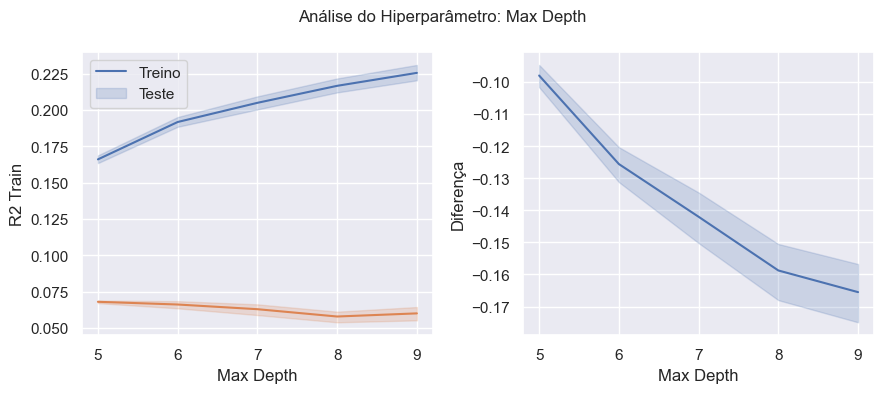

<IPython.core.display.Javascript object>

In [166]:
analise_hiperparametro('Max Depth')

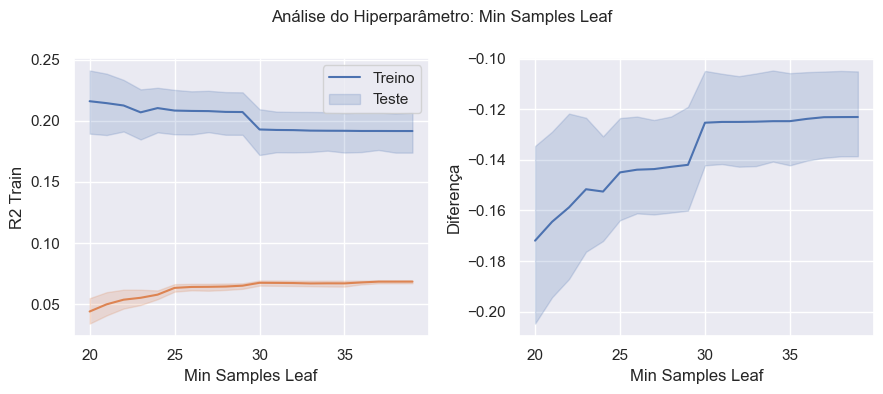

<IPython.core.display.Javascript object>

In [167]:
analise_hiperparametro('Min Samples Leaf')

In [168]:
# Divisão dos dados em conjuntos de treinamento e teste 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Criação do modelo de regressão linear
model = LinearRegression(fit_intercept=True)

# Treinamento do modelo com os dados de treinamento
model.fit(X_train, y_train)

LinearRegression()

<IPython.core.display.Javascript object>

In [169]:
# Predição dos valores para os dados de treino
y_pred = model.predict(X_train)

# Cálculo do coeficiente de determinação R²
r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)

print(f"""Coeficiente de Determinação R² em treino: {r2}
Coeficiente de Determinação MSE em treino: {mse}
Coeficiente de Determinação MAE em treino: {mae}""")

Coeficiente de Determinação R² em treino: 0.09756894055919296
Coeficiente de Determinação MSE em treino: 54453.94684672545
Coeficiente de Determinação MAE em treino: 75.81959100861344


<IPython.core.display.Javascript object>

In [171]:
# Predição dos valores para os dados de teste
y_pred = model.predict(X_test)

# Cálculo do coeficiente de determinação R²
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"""Coeficiente de Determinação R² em teste: {r2}
Coeficiente de Determinação MSE em teste: {mse}
Coeficiente de Determinação MAE em teste: {mae}""")

Coeficiente de Determinação R² em teste: 0.10236401920359961
Coeficiente de Determinação MSE em teste: 46192.94241547798
Coeficiente de Determinação MAE em teste: 71.80284719936414


<IPython.core.display.Javascript object>

## Modelagem 2

In [31]:
# Dividindo em X e y
X = df2.drop('price', axis = 1)
y = df2['price']

<IPython.core.display.Javascript object>

In [32]:
# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

<IPython.core.display.Javascript object>

###### Feature Engineering

In [33]:
train_data = pd.concat([X_train, y_train], axis=1)

# Média do bairro e distrito
media_bairros = train_data.groupby('bairro_group')['price'].mean().reset_index()
media_bairros.rename(columns={'price': 'bairro_group_mean'}, inplace=True)

media_distritos = train_data.groupby('bairro')['price'].mean().reset_index()
media_distritos.rename(columns={'price': 'bairro_mean'}, inplace=True)

X_train = pd.merge(X_train, media_bairros, on='bairro_group', how='left')
X_train = pd.merge(X_train, media_distritos, on='bairro', how='left')
X_test = pd.merge(X_test, media_bairros, on='bairro_group', how='left')
X_test = pd.merge(X_test, media_distritos, on='bairro', how='left')

<IPython.core.display.Javascript object>

In [34]:
modelo_XGBoost = XGBRegressor(n_estimators = 1000, max_depth = 8, learning_rate = 1e-3, n_jobs = -1, random_state = 0)
# modelo_LightGBM = LGBMRegressor(n_estimators = 1000, max_depth = 8, num_leaves = 2^8, learning_rate = 1e-3, n_jobs = -1, verbose = -1, random_state = 0)
modelo_catboost = CatBoostRegressor(n_estimators = 1000, max_depth = 8, learning_rate = 1e-3, random_state = 0, verbose = 0)
modelo_decision_tree = DecisionTreeRegressor(random_state = 0, max_depth = 8, min_samples_split = 2)

<IPython.core.display.Javascript object>

In [35]:
# Aplicando o Feature importance

# Instanciando o catboost encoder para variáveis categóricas
encoder = CatBoostEncoder()

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

X_train_encoded.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

for col in X_train_encoded.select_dtypes(include=['object']).columns:

    # Tratando a variável categórica
    X_train_encoded[col] = encoder.fit_transform(X_train_encoded[col], y_train)
    X_test_encoded[col] = encoder.transform(X_test_encoded[col])

# Treinando o modelo
modelo_XGBoost.fit(X_train_encoded, y_train)

r = permutation_importance(modelo_XGBoost, X_test_encoded, y_test, n_repeats = 30, random_state = 0)

<IPython.core.display.Javascript object>

In [55]:
# Criando um dataframe para mostrar as importâncias de cada variável
importances = pd.DataFrame({'Feature':X_test_encoded.columns, 'importance':r.importances_mean*100})

# Ordenando as variáveis pela importância
importances = importances.sort_values(by='importance', ascending=False)
importances

,Feature,importance
15,distancia_centro,170.098134
17,bairro_mean,14.325384
5,bairro,11.391068
8,room_type,10.341783
9,minimo_noites,4.836212
3,host_name,3.494418
14,disponibilidade_365,3.221931
6,latitude,3.127983
2,host_id,2.279958
0,id,1.854647


<IPython.core.display.Javascript object>

In [56]:
# Definindo as colunas menos importantes com base no Feature Importance
colunas_menos_importantes = importances[importances['importance'] < 0]['Feature']

# Excluindo as colunas menos importantes
X_train = X_train.drop(columns = colunas_menos_importantes)
X_test = X_test.drop(columns = colunas_menos_importantes)

KeyError: "['ultima_review'] not found in axis"

<IPython.core.display.Javascript object>

In [57]:
# Aplicando o Feature importance

# Instanciando o catboost encoder para variáveis categóricas
encoder = CatBoostEncoder()

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for col in X_train_encoded.select_dtypes(include=['object']).columns:

    # Tratando a variável categórica
    X_train_encoded[col] = encoder.fit_transform(X_train_encoded[col], y_train)
    X_test_encoded[col] = encoder.transform(X_test_encoded[col])

# Treinando o modelo
modelo_XGBoost.fit(X_train_encoded, y_train)

r_versao_2 = permutation_importance(modelo_XGBoost, X_test_encoded, y_test, n_repeats = 30, random_state = 0)

<IPython.core.display.Javascript object>

In [59]:
# Criando um dataframe para mostrar as importâncias de cada variável
importances_2 = pd.DataFrame({'Feature':X_test_encoded.columns, 'importance':r_versao_2.importances_mean*100})

# Ordenando as variáveis pela importância
importances_2 = importances_2.sort_values(by='importance', ascending=False)
importances_2

,Feature,importance
14,distancia_centro,178.145998
16,bairro_mean,20.467495
5,bairro,15.218561
8,room_type,10.594741
6,latitude,8.029743
9,minimo_noites,4.680418
3,host_name,3.349156
13,disponibilidade_365,3.222828
2,host_id,2.013336
0,id,1.679780


<IPython.core.display.Javascript object>

In [60]:
def validacao_cruzada(X, y, modelo, k):
    
    folds = KFold(n_splits = k, shuffle = True, random_state = 42)

    # Criando listas para armazenar os valores das métricas em cada fold
    erros_absolutos = list()
    erros_quadrados = list()
    r2 = list()

    # Será aplicado o método "split" no objeto folds, que retornará uma lista 
    # com os índices das instâncias que pertencem ao conjunto de treino e 
    # outra com os índices das instâncias que pertencem ao conjunto de teste
    for k, (train_index, test_index) in enumerate(folds.split(X, y)):
    
        print("#-"*8 + f"Fold: {k+1}" + "-#"*8)

        # Dividindo os dados em treino e teste para cada um dos folds
        X_train_interno, y_train_interno = X.iloc[train_index, :], y.iloc[train_index]
        X_test_interno, y_test_interno = X.iloc[test_index, :], y.iloc[test_index]
        # train_index e test_index: São os índices das instâncias do conjunto 
        # de treino e teste, respectivamente, selecionados em cada um dos folds
        
        # Instanciando o CatBoost Encoder
        encoder = CatBoostEncoder()

        # Criando um imputer para preencher com a moda os valores faltantes de variáveis categóricas
        cat_imputer = SimpleImputer(strategy='most_frequent')
        
        # Criando um imputer para preencher com a mediana os valores faltantes de variáveis numéricas
        num_imputer = SimpleImputer(strategy='median')

        # Criando pipelines para variáveis categóricas e numéricas que preenche os valores faltantes
        cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
        num_pipeline = Pipeline([('imputer', num_imputer)])

        # Definindo quem s"ao as variãveis num~ericas e categóricas
        cat_cols = X_train_interno.select_dtypes(include=['object']).columns
        num_cols = X_train_interno.select_dtypes(exclude=['object']).columns

        # Aplicando os pipelines no conjunto de treinamento para preencher valores faltantes em colunas categóricas e numéricas
        X_train_interno[cat_cols] = cat_pipeline.fit_transform(X_train_interno[cat_cols], y_train_interno)
        X_train_interno[num_cols] = num_pipeline.fit_transform(X_train_interno[num_cols])

        # Aplicando os pipelines ao conjunto de teste para preencher valores faltantes em colunas categóricas e numéricas
        X_test_interno[cat_cols] = cat_pipeline.transform(X_test_interno[cat_cols])
        X_test_interno[num_cols] = num_pipeline.transform(X_test_interno[num_cols])

        # Treinando o modelo
        modelo.fit(X_train_interno, y_train_interno)

        # Obtendo as previsões do modelo
        y_pred = modelo.predict(X_test_interno)
    
        # Calculando as métricas para o fold em questão
        r2score = r2_score(y_test_interno, y_pred)
        mse = mean_squared_error(y_test_interno, y_pred)
        mae = mean_absolute_error(y_test_interno, y_pred)

        # Armazenando as métricas nas listas criadas
        erros_absolutos.append(mae)
        erros_quadrados.append(mse)
        r2.append(r2score)

        # Exibindo as métricas para cada um dos folds
        print(f"MAE: {mae:.3f}")
        print(f"MSE: {mse:.3f}")
        print(f"R2: {r2score:.3f}")

    # Transformando as listas erros_absolutos, erros_quadrados e r2 em arrays, para fazer operações matemáticas
    erros_absolutos = np.array(erros_absolutos)
    erros_quadrados = np.array(erros_quadrados)
    r2 = np.array(r2)

    # Calculando a média de todas as métricas
    media_mae = np.mean(erros_absolutos)
    media_mse = np.mean(erros_quadrados)
    media_r2 = np.mean(r2)

    # Calculando o desvio padrão de todas as métricas
    std_mae = np.std(erros_absolutos)
    std_mse = np.std(erros_quadrados)
    std_r2 = np.std(r2)
    
    print("#-"*6 + "Exibindo a média das métricas obtidas" + "-#"*6)
    print(f"Média do MAE: {media_mae:.3f} +/- {std_mae:.3f}")
    print(f"Média do MSE: {media_mse:.3f} +/- {std_mse:.3f}")
    print(f"Média do R2: {media_r2:.3f} +/- {std_r2:.3f}")

<IPython.core.display.Javascript object>

In [61]:
validacao_cruzada(X, y, modelo_XGBoost, k=5)

#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
MAE: 68.781
MSE: 52753.514
R2: 0.085
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
MAE: 71.099
MSE: 53158.989
R2: 0.107
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
MAE: 72.513
MSE: 64158.865
R2: 0.152
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
MAE: 69.807
MSE: 53080.323
R2: 0.106
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#
MAE: 67.154
MSE: 27986.973
R2: 0.226
#-#-#-#-#-#-Exibindo a média das métricas obtidas-#-#-#-#-#-#
Média do MAE: 69.871 +/- 1.847
Média do MSE: 50227.733 +/- 11931.781
Média do R2: 0.135 +/- 0.050


<IPython.core.display.Javascript object>

In [62]:
validacao_cruzada(X, y, modelo_catboost, k=5)

#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
MAE: 69.874
MSE: 52159.160
R2: 0.095
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
MAE: 70.881
MSE: 52207.275
R2: 0.123
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
MAE: 74.924
MSE: 67237.671
R2: 0.112
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
MAE: 71.121
MSE: 51356.153
R2: 0.135
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#
MAE: 69.439
MSE: 29353.159
R2: 0.188
#-#-#-#-#-#-Exibindo a média das métricas obtidas-#-#-#-#-#-#
Média do MAE: 71.248 +/- 1.940
Média do MSE: 50462.684 +/- 12113.894
Média do R2: 0.130 +/- 0.031


<IPython.core.display.Javascript object>

In [63]:
validacao_cruzada(X, y, modelo_decision_tree, k=5)

#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
MAE: 69.728
MSE: 73011.437
R2: -0.266
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
MAE: 68.929
MSE: 57447.174
R2: 0.035
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
MAE: 69.413
MSE: 64129.857
R2: 0.153
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
MAE: 70.519
MSE: 75827.308
R2: -0.277
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#
MAE: 65.889
MSE: 35569.474
R2: 0.016
#-#-#-#-#-#-Exibindo a média das métricas obtidas-#-#-#-#-#-#
Média do MAE: 68.896 +/- 1.590
Média do MSE: 61197.050 +/- 14374.003
Média do R2: -0.068 +/- 0.173


<IPython.core.display.Javascript object>

In [64]:
def tunagem_hiperparametros(trial, k=5):

    # Tunagem 
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1, step=0.1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)

    folds = KFold(n_splits = k, shuffle = True, random_state = 42)

    # Criando listas para armazenar os valores das métricas em cada fold
    erros_absolutos = list()
    erros_quadrados = list()
    r2 = list()

    # Será aplicado o método "split" no objeto folds, que retornará uma lista 
    # com os índices das instâncias que pertencem ao conjunto de treino e 
    # outra com os índices das instâncias que pertencem ao conjunto de teste
    
    for k, (train_index, test_index) in enumerate(folds.split(X, y)):
    
        print("#-"*8 + f"Fold: {k+1}" + "-#"*8)

        # Dividindo os dados em treino e teste para cada um dos folds
        X_train_interno, y_train_interno = X.iloc[train_index, :], y.iloc[train_index]
        X_test_interno, y_test_interno = X.iloc[test_index, :], y.iloc[test_index]
        # train_index e test_index: São os índices das instâncias do conjunto 
        # de treino e teste, respectivamente, selecionados em cada um dos folds

        # Instanciando o CatBoost Encoder
        encoder = CatBoostEncoder()

        # Criando um imputer para preencher com a moda os valores faltantes de variáveis categóricas
        cat_imputer = SimpleImputer(strategy='most_frequent')

        # Criando um imputer para preencher com a mediana os valores faltantes de variáveis numéricas
        num_imputer = SimpleImputer(strategy='median')

        # Criando pipelines para variáveis categóricas e numéricas que preenche os valores faltantes
        cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
        num_pipeline = Pipeline([('imputer', num_imputer)])

        # cat_cols e num_cols são trazidos para cá para incluir as novas variáveis criadas no feature engineering
        cat_cols = X_train_interno.select_dtypes(include=['object']).columns
        num_cols = X_train_interno.select_dtypes(exclude=['object']).columns

        # Aplicando os pipelines no conjunto de treinamento para preencher valores faltantes em colunas categóricas e numéricas
        X_train_interno[cat_cols] = cat_pipeline.fit_transform(X_train_interno[cat_cols], y_train_interno)
        X_train_interno[num_cols] = num_pipeline.fit_transform(X_train_interno[num_cols])

        # Aplicando os pipelines ao conjunto de teste para preencher valores faltantes em colunas categóricas e numéricas
        X_test_interno[cat_cols] = cat_pipeline.transform(X_test_interno[cat_cols])
        X_test_interno[num_cols] = num_pipeline.transform(X_test_interno[num_cols])

        # Treinando o modelo
        modelo_XGBoost.fit(X_train_interno, y_train_interno)

        # Obtendo as previsões do modelo
        y_pred = modelo_XGBoost.predict(X_test_interno)
    
        # Calculando as métricas para o fold em questão
        r2score = r2_score(y_test_interno, y_pred)
        mse = mean_squared_error(y_test_interno, y_pred)
        mae = mean_absolute_error(y_test_interno, y_pred)

        # Armazenando as métricas nas listas criadas
        erros_absolutos.append(mae)
        erros_quadrados.append(mse)
        r2.append(r2score)

    # Transformando as listas erros_absolutos, erros_quadrados e r2 em arrays, para fazer operações matemáticas
    erros_absolutos = np.array(erros_absolutos)
    erros_quadrados = np.array(erros_quadrados)
    r2 = np.array(r2)

    # Calculando a média de todas as métricas
    media_mae = np.mean(erros_absolutos)
    media_mse = np.mean(erros_quadrados)
    media_r2 = np.mean(r2)

    # Calculando o desvio padrão de todas as métricas
    std_mae = np.std(erros_absolutos)
    std_mse = np.std(erros_quadrados)
    std_r2 = np.std(r2)

    return media_mse

study = opt.create_study(direction='minimize')
study.optimize(tunagem_hiperparametros, n_trials = 5)

[I 2024-02-08 00:01:12,168] A new study created in memory with name: no-name-1843e2c1-5c32-449b-96d5-3b2c7a9544a6


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-02-08 00:01:28,314] Trial 0 finished with value: 50227.73300065754 and parameters: {'learning_rate': 0.0587123293543678, 'max_depth': 2, 'subsample': 1.0, 'colsample_bytree': 0.9, 'min_child_weight': 7}. Best is trial 0 with value: 50227.73300065754.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-02-08 00:01:44,014] Trial 1 finished with value: 50227.73300065754 and parameters: {'learning_rate': 0.0022671447275967333, 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 0.6, 'min_child_weight': 5}. Best is trial 0 with value: 50227.73300065754.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-02-08 00:02:00,445] Trial 2 finished with value: 50227.73300065754 and parameters: {'learning_rate': 0.00516941904599988, 'max_depth': 7, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 1}. Best is trial 0 with value: 50227.73300065754.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-02-08 00:02:16,578] Trial 3 finished with value: 50227.73300065754 and parameters: {'learning_rate': 0.03592129842694849, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.8, 'min_child_weight': 4}. Best is trial 0 with value: 50227.73300065754.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-02-08 00:02:32,877] Trial 4 finished with value: 50227.73300065754 and parameters: {'learning_rate': 0.002454405408844346, 'max_depth': 9, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 1}. Best is trial 0 with value: 50227.73300065754.


<IPython.core.display.Javascript object>

In [65]:
params = {'learning_rate': 0.002454405408844346, 'max_depth': 9, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 1}

<IPython.core.display.Javascript object>

In [66]:
modelo_XGBoost = XGBRegressor(n_estimators = 1000, n_jobs=-1, random_state=0, **params)

<IPython.core.display.Javascript object>

In [67]:
validacao_cruzada(X, y, modelo_XGBoost, k=10)

#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
MAE: 63.548
MSE: 62541.298
R2: 0.095
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
MAE: 61.737
MSE: 39800.827
R2: 0.138
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
MAE: 60.988
MSE: 29182.569
R2: 0.253
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
MAE: 64.809
MSE: 66272.456
R2: 0.171
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#
MAE: 65.535
MSE: 57143.787
R2: 0.238
#-#-#-#-#-#-#-#-Fold: 6-#-#-#-#-#-#-#-#
MAE: 67.552
MSE: 65370.250
R2: 0.144
#-#-#-#-#-#-#-#-Fold: 7-#-#-#-#-#-#-#-#
MAE: 63.512
MSE: 55109.060
R2: 0.138
#-#-#-#-#-#-#-#-Fold: 8-#-#-#-#-#-#-#-#
MAE: 62.133
MSE: 40432.866
R2: 0.263
#-#-#-#-#-#-#-#-Fold: 9-#-#-#-#-#-#-#-#
MAE: 60.117
MSE: 18399.560
R2: 0.293
#-#-#-#-#-#-#-#-Fold: 10-#-#-#-#-#-#-#-#
MAE: 62.160
MSE: 33688.630
R2: 0.272
#-#-#-#-#-#-Exibindo a média das métricas obtidas-#-#-#-#-#-#
Média do MAE: 63.209 +/- 2.144
Média do MSE: 46794.130 +/- 15894.178
Média do R2: 0.200 +/- 0.067


<IPython.core.display.Javascript object>